# 🔄 Week 4: Data Transformation with dbt
## จากข้อมูลดิบสู่ข้อมูลที่พร้อมใช้งาน

### วัตถุประสงค์การเรียนรู้
หลังจากเรียนจบแล้ว นักศึกษาจะสามารถ:
1. **อธิบาย** ความสำคัญของ Data Transformation ในระบบข้อมูล
2. **เข้าใจ** Medallion Architecture และแต่ละ Layer
3. **ประยุกต์ใช้** dbt ในการสร้าง Data Pipeline
4. **ปฏิบัติ** การทำความสะอาดและ Standardize ข้อมูล
5. **ตรวจสอบ** คุณภาพข้อมูลด้วยการทดสอบ

---

## 📋 เตรียมความพร้อม

### ติดตั้ง Dependencies ที่จำเป็น

In [ ]:
# # ติดตั้ง packages ที่จำเป็น
# !pip install duckdb pandas pyarrow minio python-dotenv
# !pip install dbt-duckdb

## 🤔 ปัญหาของข้อมูลดิบ

### สถานการณ์จริง - ร้านกาแฟ Brew-Right

ลองนึกภาพว่าคุณเป็นเจ้าของร้านกาแฟที่มีหลายสาขา แต่ละสาขาใช้ระบบ POS ต่างกัน:

- **สาขา A**: บันทึกวันที่เป็น `"15/01/2024"`
- **สาขา B**: บันทึกวันที่เป็น `"2024-01-15"`  
- **สาขา C**: บันทึกวันที่เป็น `"Jan 15, 2024"`

**ผลที่ตามมา:**
- ❌ วิเคราะห์ข้อมูลไม่ได้
- ❌ รายงานผิดพลาด
- ❌ เสียเวลาในการแก้ไข

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import json

# สร้างตัวอย่างข้อมูลดิบที่มีปัญหา
raw_data_problems = {
    'branch_a': {
        'order_id': 'ORD-001',
        'date': '15/01/2024',
        'items': 'Cappuccino x2, Croissant x1',
        'total': '฿285.00',
        'customer': 'John_Doe_123'
    },
    'branch_b': {
        'order_id': 'ORD-002', 
        'date': '2024-01-15',
        'items': 'Latte x1, Muffin x2',
        'total': '$12.50',
        'customer': 'jane.smith@email.com'
    },
    'branch_c': {
        'order_id': 'ORD-003',
        'date': 'Jan 15, 2024',
        'items': 'Espresso x3',
        'total': '€9.75',
        'customer': 'Bob Wilson'
    }
}

print("🔴 ตัวอย่างข้อมูลดิบที่มีปัญหา:")
for branch, data in raw_data_problems.items():
    print(f"\n{branch.upper()}:")
    for key, value in data.items():
        print(f"  {key}: {value}")

🔴 ตัวอย่างข้อมูลดิบที่มีปัญหา:

BRANCH_A:
  order_id: ORD-001
  date: 15/01/2024
  items: Cappuccino x2, Croissant x1
  total: ฿285.00
  customer: John_Doe_123

BRANCH_B:
  order_id: ORD-002
  date: 2024-01-15
  items: Latte x1, Muffin x2
  total: $12.50
  customer: jane.smith@email.com

BRANCH_C:
  order_id: ORD-003
  date: Jan 15, 2024
  items: Espresso x3
  total: €9.75
  customer: Bob Wilson


## 🏅 Medallion Architecture: โครงสร้างข้อมูลแบบขั้นบันได

### แนวคิดการจัดระบบข้อมูลแบบ 3 ชั้น

```
Raw Data → Bronze → Silver → Gold → Business Value
```

**หลักการ:**
- แต่ละชั้นมีจุดประสงค์ชัดเจน
- ข้อมูลไหลไปข้างหน้าเท่านั้น
- สามารถย้อนกลับตรวจสอบได้

/tmp/ipykernel_8634/467232800.py:50: UserWarning: Glyph 127941 (\N{SPORTS MEDAL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_8634/467232800.py:50: UserWarning: Glyph 3650 (\N{THAI CHARACTER SARA O}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_8634/467232800.py:50: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_8634/467232800.py:50: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_8634/467232800.py:50: UserWarning: Glyph 3591 (\N{THAI CHARACTER NGO NGU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_8634/467232800.py:50: UserWarning: Glyph 3626 (\N{THAI CHARACTER SO SUA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_8634/467232800.py:50: UserWarning: Glyph 3657 (\N{THAI CHARACTER MAI THO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_8634/467232800.py:50: UserWa

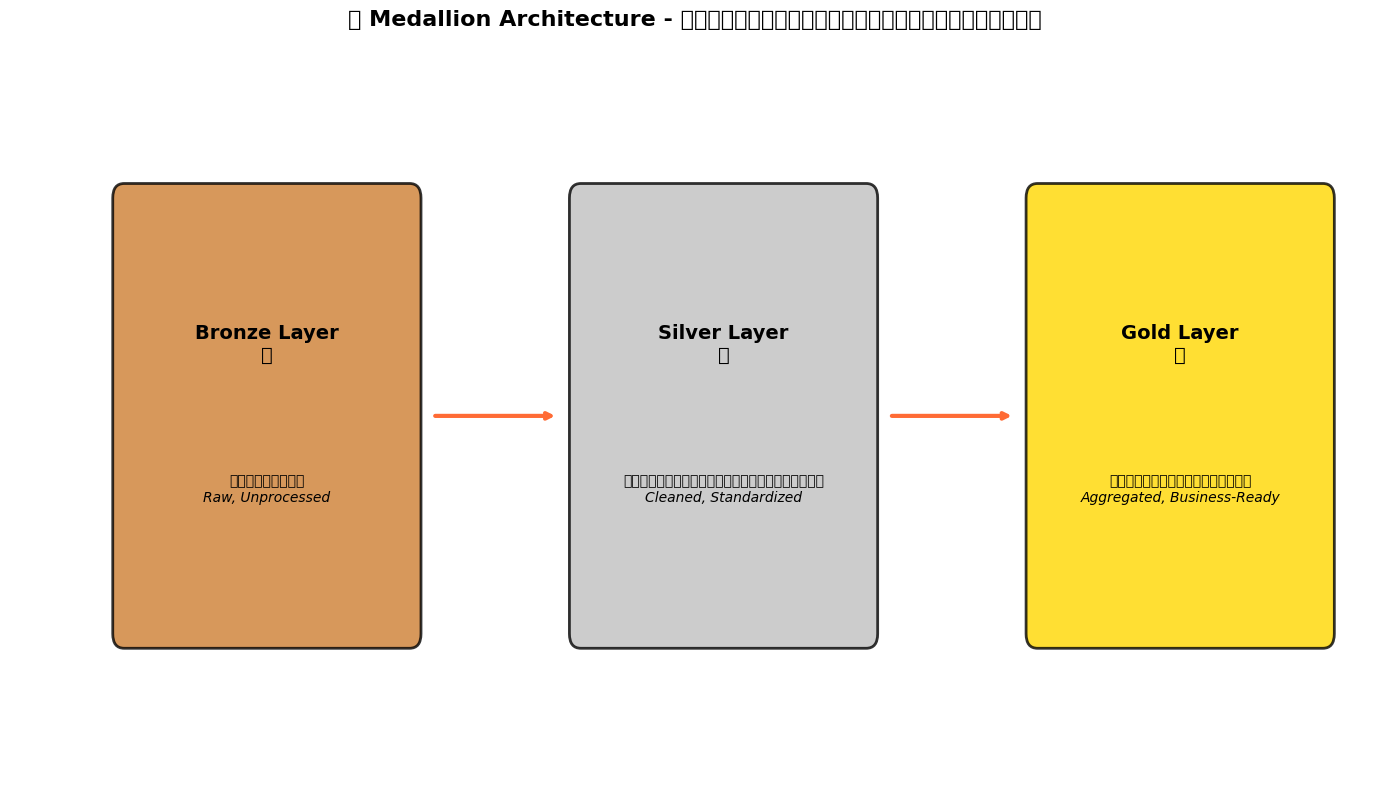


📊 เปรียบเทียบ 3 Layers:
      Aspect  Bronze 🥉     Silver 🥈     Gold 🥇
Data Quality       Raw        Clean Aggregated
      Schema  Variable Standardized  Optimized
     Purpose   Archive   Foundation   Business
       Users Engineers     Analysts   Everyone
      Volume   Highest       Medium     Lowest
 Query Speed      Slow       Medium       Fast


In [2]:
# สร้าง visualization ของ Medallion Architecture
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# กำหนดสี
bronze_color = '#CD7F32'
silver_color = '#C0C0C0' 
gold_color = '#FFD700'

# สร้าง boxes สำหรับแต่ละ layer
layers = [
    {'name': 'Bronze Layer\n🥉', 'desc': 'ข้อมูลดิบ\nRaw, Unprocessed', 'color': bronze_color, 'x': 1},
    {'name': 'Silver Layer\n🥈', 'desc': 'ข้อมูลที่ทำความสะอาดแล้ว\nCleaned, Standardized', 'color': silver_color, 'x': 5},
    {'name': 'Gold Layer\n🥇', 'desc': 'ข้อมูลพร้อมใช้งาน\nAggregated, Business-Ready', 'color': gold_color, 'x': 9}
]

for layer in layers:
    # สร้าง fancy box
    box = FancyBboxPatch(
        (layer['x'], 2), 2.5, 3,
        boxstyle="round,pad=0.1",
        facecolor=layer['color'],
        edgecolor='black',
        linewidth=2,
        alpha=0.8
    )
    ax.add_patch(box)
    
    # เพิ่มข้อความ
    ax.text(layer['x'] + 1.25, 4, layer['name'], 
            ha='center', va='center', fontsize=14, fontweight='bold')
    ax.text(layer['x'] + 1.25, 3, layer['desc'], 
            ha='center', va='center', fontsize=10, style='italic')

# เพิ่มลูกศร
arrow_props = dict(arrowstyle='->', lw=3, color='#FF6B35')
ax.annotate('', xy=(4.8, 3.5), xytext=(3.7, 3.5), arrowprops=arrow_props)
ax.annotate('', xy=(8.8, 3.5), xytext=(7.7, 3.5), arrowprops=arrow_props)

# ตั้งค่า plot
ax.set_xlim(0, 12)
ax.set_ylim(1, 6)
ax.set_title('🏅 Medallion Architecture - โครงสร้างข้อมูลแบบขั้นบันได', 
             fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.show()

print("\n📊 เปรียบเทียบ 3 Layers:")
comparison_data = {
    'Aspect': ['Data Quality', 'Schema', 'Purpose', 'Users', 'Volume', 'Query Speed'],
    'Bronze 🥉': ['Raw', 'Variable', 'Archive', 'Engineers', 'Highest', 'Slow'],
    'Silver 🥈': ['Clean', 'Standardized', 'Foundation', 'Analysts', 'Medium', 'Medium'],
    'Gold 🥇': ['Aggregated', 'Optimized', 'Business', 'Everyone', 'Lowest', 'Fast']
}

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

## 🛠️ dbt - Modern Data Transformation Tool

### ปัญหาแบบเดิม vs วิธีแก้ด้วย dbt

**ปัญหาแบบเดิม:**
- SQL Scripts กระจัดกระจาย
- ไม่มี Version Control
- ไม่มีการทดสอบ  
- Documentation หายไป
- จัดการ Dependencies ยาก

**วิธีแก้ด้วย dbt:**
- ✅ **SQL-Based** ใช้ SQL ที่คุ้นเคย
- ✅ **Version Control** Git integration
- ✅ **Testing** Built-in data tests
- ✅ **Documentation** Auto-generated docs
- ✅ **Dependencies** Smart execution order

### 🚀 ติดตั้งและตั้งค่า dbt

เราจะใช้ DuckDB เป็นฐานข้อมูลสำหรับ lab นี้ เพราะเป็น in-memory database ที่เหมาะสำหรับการเรียนรู้

In [3]:
import os
import duckdb
from pathlib import Path

# สร้างโฟลเดอร์สำหรับ dbt project
dbt_project_path = Path('../dbt_project')
dbt_project_path.mkdir(exist_ok=True)

# สร้างไฟล์ dbt_project.yml
dbt_project_yml = """
name: 'brew_right'
version: '1.0.0'
config-version: 2

profile: 'brew_right'

model-paths: ["models"]
analysis-paths: ["analyses"]
test-paths: ["tests"]
seed-paths: ["seeds"]
macro-paths: ["macros"]
snapshot-paths: ["snapshots"]

target-path: "target"
clean-targets:
  - "target"
  - "dbt_packages"

models:
  brew_right:
    staging:
      +materialized: view
    marts:
      +materialized: table
""".strip()

with open(dbt_project_path / 'dbt_project.yml', 'w') as f:
    f.write(dbt_project_yml)

print("✅ สร้าง dbt_project.yml เรียบร้อยแล้ว")

# สร้างโฟลเดอร์โครงสร้าง
folders = ['models/staging', 'models/marts', 'tests', 'macros', 'seeds']
for folder in folders:
    (dbt_project_path / folder).mkdir(parents=True, exist_ok=True)

print("✅ สร้างโครงสร้างโฟลเดอร์ dbt เรียบร้อยแล้ว")

✅ สร้าง dbt_project.yml เรียบร้อยแล้ว
✅ สร้างโครงสร้างโฟลเดอร์ dbt เรียบร้อยแล้ว


In [4]:
# สร้าง profiles.yml สำหรับ DuckDB
profiles_yml = """
brew_right:
  outputs:
    dev:
      type: duckdb
      path: './brew_right.duckdb'
      threads: 4
  target: dev
""".strip()

# สร้างโฟลเดอร์ .dbt ใน home directory (ถ้ายังไม่มี)
dbt_home = Path.home() / '.dbt'
dbt_home.mkdir(exist_ok=True)

with open(dbt_home / 'profiles.yml', 'w') as f:
    f.write(profiles_yml)

print("✅ สร้าง profiles.yml เรียบร้อยแล้ว")
print(f"📁 ไฟล์อยู่ที่: {dbt_home / 'profiles.yml'}")

✅ สร้าง profiles.yml เรียบร้อยแล้ว
📁 ไฟล์อยู่ที่: /home/vscode/.dbt/profiles.yml


### 📊 เตรียมข้อมูลตัวอย่างใน DuckDB

เราจะสร้างข้อมูลตัวอย่างใน DuckDB เพื่อใช้ในการทดสอบ dbt models

In [5]:
# เชื่อมต่อ DuckDB และสร้างข้อมูลตัวอย่าง
conn = duckdb.connect('../dbt_project/brew_right.duckdb')

# สร้าง schema สำหรับ bronze layer
conn.execute("CREATE SCHEMA IF NOT EXISTS bronze")
conn.execute("CREATE SCHEMA IF NOT EXISTS silver")
conn.execute("CREATE SCHEMA IF NOT EXISTS gold")

# สร้างตาราง bronze_orders
bronze_orders_sql = """
CREATE OR REPLACE TABLE bronze.orders AS
SELECT * FROM (
    VALUES 
    ('ORD-001', '15/01/2024', 'Cappuccino x2, Croissant x1', '฿285.00', 'John_Doe_123', 'branch_a', '2024-01-15 10:30:00'),
    ('ORD-002', '2024-01-15', 'Latte x1, Muffin x2', '$12.50', 'jane.smith@email.com', 'branch_b', '2024-01-15 11:00:00'),
    ('ORD-003', 'Jan 15, 2024', 'Espresso x3', '€9.75', 'Bob Wilson', 'branch_c', '2024-01-15 12:00:00'),
    ('ORD-004', '16/01/2024', 'Americano x1, Cookie x2', '฿180.00', 'alice_brown', 'branch_a', '2024-01-16 09:15:00'),
    ('ORD-005', '2024-01-16', 'Cappuccino x1, Sandwich x1', '$15.75', 'mike.jones@email.com', 'branch_b', '2024-01-16 14:30:00'),
    ('ORD-006', 'Jan 16, 2024', 'Latte x2', '€8.50', 'Sarah Davis', 'branch_c', '2024-01-16 16:45:00')
) AS t(order_id, date, items, total, customer, source_branch, created_at)
"""

conn.execute(bronze_orders_sql)

# ตรวจสอบข้อมูล
result = conn.execute("SELECT * FROM bronze.orders").fetchall()
columns = [desc[0] for desc in conn.description]

print("🥉 ข้อมูลใน Bronze Layer (bronze.orders):")
df_bronze = pd.DataFrame(result, columns=columns)
print(df_bronze.to_string(index=False))

conn.close()

🥉 ข้อมูลใน Bronze Layer (bronze.orders):
order_id         date                       items   total             customer source_branch          created_at
 ORD-001   15/01/2024 Cappuccino x2, Croissant x1 ฿285.00         John_Doe_123      branch_a 2024-01-15 10:30:00
 ORD-002   2024-01-15         Latte x1, Muffin x2  $12.50 jane.smith@email.com      branch_b 2024-01-15 11:00:00
 ORD-003 Jan 15, 2024                 Espresso x3   €9.75           Bob Wilson      branch_c 2024-01-15 12:00:00
 ORD-004   16/01/2024     Americano x1, Cookie x2 ฿180.00          alice_brown      branch_a 2024-01-16 09:15:00
 ORD-005   2024-01-16  Cappuccino x1, Sandwich x1  $15.75 mike.jones@email.com      branch_b 2024-01-16 14:30:00
 ORD-006 Jan 16, 2024                    Latte x2   €8.50          Sarah Davis      branch_c 2024-01-16 16:45:00


### 📄 สร้าง dbt Models

#### 1. Sources Configuration
เริ่มต้นด้วยการกำหนด sources ที่เราจะใช้

In [6]:
# สร้างไฟล์ sources.yml
sources_yml = """
version: 2

sources:
  - name: bronze
    description: "Bronze layer - raw data from various sources"
    schema: bronze
    tables:
      - name: orders
        description: "Raw order data from different POS systems"
        columns:
          - name: order_id
            description: "Unique order identifier"
            tests:
              - not_null
          - name: date
            description: "Order date in various formats"
          - name: items
            description: "Ordered items as string"
          - name: total
            description: "Total amount with currency symbol"
          - name: customer
            description: "Customer identifier in various formats"
          - name: source_branch
            description: "Source branch identifier"
          - name: created_at
            description: "Record creation timestamp"
""".strip()

with open(dbt_project_path / 'models' / 'sources.yml', 'w') as f:
    f.write(sources_yml)

print("✅ สร้าง sources.yml เรียบร้อยแล้ว")

✅ สร้าง sources.yml เรียบร้อยแล้ว


#### 2. Staging Model - Silver Layer
สร้าง staging model เพื่อทำความสะอาดข้อมูลจาก Bronze ไป Silver

In [7]:
# สร้าง staging model: stg_orders.sql
stg_orders_sql = """
{{ config(
    materialized='table',
    tags=['silver', 'staging']
) }}

WITH raw_orders AS (
    SELECT * FROM {{ source('bronze', 'orders') }}
),

cleaned AS (
    SELECT 
        order_id,
        
        -- แปลงวันที่จากหลายรูปแบบให้เป็นมาตรฐาน ISO
        CASE 
            WHEN date LIKE '%/%/%' THEN 
                CAST(CONCAT(
                    SPLIT_PART(date, '/', 3), '-',
                    LPAD(SPLIT_PART(date, '/', 2), 2, '0'), '-',
                    LPAD(SPLIT_PART(date, '/', 1), 2, '0')
                ) AS DATE)
            WHEN date LIKE '%-%-%' THEN 
                CAST(date AS DATE)
            WHEN date LIKE '%,%' THEN
                STRPTIME(date, '%b %d, %Y')::DATE
            ELSE NULL
        END as order_date,
        
        -- ทำความสะอาดราคา: ลบสัญลักษณ์สกุลเงินและแปลงเป็น THB
        CASE 
            WHEN total LIKE '฿%' THEN 
                CAST(REPLACE(REPLACE(total, '฿', ''), ',', '') AS DECIMAL(10,2))
            WHEN total LIKE '$%' THEN 
                CAST(REPLACE(REPLACE(total, '$', ''), ',', '') AS DECIMAL(10,2)) * 35.0
            WHEN total LIKE '€%' THEN 
                CAST(REPLACE(REPLACE(total, '€', ''), ',', '') AS DECIMAL(10,2)) * 38.0
            ELSE NULL
        END as total_amount_thb,
        
        -- Normalize customer ID
        CASE 
            WHEN customer LIKE '%@%' THEN 
                LOWER(REPLACE(SPLIT_PART(customer, '@', 1), '.', '_'))
            WHEN customer LIKE '% %' THEN 
                LOWER(REPLACE(customer, ' ', '_'))
            ELSE 
                LOWER(customer)
        END as customer_id,
        
        items,
        source_branch,
        CURRENT_TIMESTAMP as processed_at,
        created_at as source_created_at
        
    FROM raw_orders
    WHERE order_id IS NOT NULL
      AND total IS NOT NULL
)

SELECT * FROM cleaned
WHERE order_date IS NOT NULL
  AND total_amount_thb > 0
  AND customer_id IS NOT NULL
""".strip()

with open(dbt_project_path / 'models' / 'staging' / 'stg_orders.sql', 'w') as f:
    f.write(stg_orders_sql)

print("✅ สร้าง stg_orders.sql เรียบร้อยแล้ว")

✅ สร้าง stg_orders.sql เรียบร้อยแล้ว


#### 3. Marts Models - Gold Layer
สร้าง marts models สำหรับ business-ready data

In [8]:
# สร้าง marts model: daily_sales_summary.sql
daily_sales_sql = """
{{ config(
    materialized='table',
    tags=['gold', 'marts', 'daily']
) }}

SELECT 
    order_date,
    COUNT(*) as total_orders,
    COUNT(DISTINCT customer_id) as unique_customers,
    SUM(total_amount_thb) as total_revenue_thb,
    AVG(total_amount_thb) as avg_order_value_thb,
    MIN(total_amount_thb) as min_order_value_thb,
    MAX(total_amount_thb) as max_order_value_thb,
    
    COUNT(CASE WHEN source_branch = 'branch_a' THEN 1 END) as branch_a_orders,
    COUNT(CASE WHEN source_branch = 'branch_b' THEN 1 END) as branch_b_orders,
    COUNT(CASE WHEN source_branch = 'branch_c' THEN 1 END) as branch_c_orders,
    
    CURRENT_TIMESTAMP as created_at
    
FROM {{ ref('stg_orders') }}
GROUP BY order_date
ORDER BY order_date
""".strip()

with open(dbt_project_path / 'models' / 'marts' / 'daily_sales_summary.sql', 'w') as f:
    f.write(daily_sales_sql)

print("✅ สร้าง daily_sales_summary.sql เรียบร้อยแล้ว")

✅ สร้าง daily_sales_summary.sql เรียบร้อยแล้ว


### 🚀 รัน dbt Models

ตอนนี้เราจะทดสอบรัน dbt models ที่เราสร้างขึ้น

In [9]:
import subprocess
import os

# เปลี่ยน working directory ไป dbt project
os.chdir('../dbt_project')

# ทดสอบ dbt connection
print("🔍 ทดสอบการเชื่อมต่อ dbt...")
try:
    result = subprocess.run(['dbt', 'debug'], capture_output=True, text=True, timeout=30)
    print("Debug Output:")
    print(result.stdout)
    if result.stderr:
        print("Errors:")
        print(result.stderr)
except subprocess.TimeoutExpired:
    print("❌ dbt debug timeout")
except Exception as e:
    print(f"❌ Error running dbt debug: {e}")

# กลับไปที่ notebook directory
os.chdir('../notebooks')

🔍 ทดสอบการเชื่อมต่อ dbt...
Debug Output:
08:04:05  Running with dbt=1.7.4
08:04:05  dbt version: 1.7.4
08:04:05  python version: 3.10.18
08:04:05  python path: /usr/local/bin/python3.10
08:04:05  os info: Linux-6.8.0-1030-azure-x86_64-with-glibc2.31
08:04:05  Using profiles dir at /home/vscode/.dbt
08:04:05  Using profiles.yml file at /home/vscode/.dbt/profiles.yml
08:04:05  Using dbt_project.yml file at /workspaces/brew-right-660710710/dbt_project/dbt_project.yml
08:04:05  adapter type: duckdb
08:04:05  adapter version: 1.7.2
08:04:05  Configuration:
08:04:05    profiles.yml file [OK found and valid]
08:04:05    dbt_project.yml file [OK found and valid]
08:04:05  Required dependencies:
08:04:05   - git [OK found]

08:04:05  Connection:
08:04:05    database: brew_right
08:04:05    schema: main
08:04:05    path: ./brew_right.duckdb
08:04:05    config_options: None
08:04:05    extensions: None
08:04:05    settings: None
08:04:05    external_root: .
08:04:05    use_credential_provider: No

In [10]:
# รัน dbt models
os.chdir('../dbt_project')

print("🚀 รัน dbt models...")
try:
    result = subprocess.run(['dbt', 'run'], capture_output=True, text=True, timeout=60)
    print("Run Output:")
    print(result.stdout)
    if result.stderr:
        print("Errors:")
        print(result.stderr)
except subprocess.TimeoutExpired:
    print("❌ dbt run timeout")
except Exception as e:
    print(f"❌ Error running dbt: {e}")

os.chdir('../notebooks')

🚀 รัน dbt models...
Run Output:
08:04:13  Running with dbt=1.7.4
08:04:13  Registered adapter: duckdb=1.7.2
08:04:13  Unable to do partial parsing because saved manifest not found. Starting full parse.
08:04:14  Found 2 models, 1 test, 1 source, 0 exposures, 0 metrics, 391 macros, 0 groups, 0 semantic models
08:04:14  
08:04:14  Concurrency: 4 threads (target='dev')
08:04:14  
08:04:14  1 of 2 START sql table model main.stg_orders ................................... [RUN]
08:04:15  1 of 2 OK created sql table model main.stg_orders .............................. [OK in 0.11s]
08:04:15  2 of 2 START sql table model main.daily_sales_summary .......................... [RUN]
08:04:15  2 of 2 OK created sql table model main.daily_sales_summary ..................... [OK in 0.10s]
08:04:15  
08:04:15  Finished running 2 table models in 0 hours 0 minutes and 0.33 seconds (0.33s).
08:04:15  
08:04:15  Completed successfully
08:04:15  
08:04:15  Done. PASS=2 WARN=0 ERROR=0 SKIP=0 TOTAL=2



### 📊 ตรวจสอบผลลัพธ์

ดูข้อมูลที่ถูกสร้างขึ้นใน Silver และ Gold layers

In [11]:
# เชื่อมต่อ DuckDB และดูผลลัพธ์
conn = duckdb.connect('../dbt_project/brew_right.duckdb')

print("🥈 Silver Layer - Staging Orders:")
try:
    result = conn.execute("SELECT * FROM main.stg_orders ORDER BY order_date").fetchall()
    columns = [desc[0] for desc in conn.description]
    df_silver = pd.DataFrame(result, columns=columns)
    print(df_silver.to_string(index=False))
except Exception as e:
    print(f"❌ Error querying stg_orders: {e}")

print("\n" + "="*80)
print("🥇 Gold Layer - Daily Sales Summary:")
try:
    result = conn.execute("SELECT * FROM main.daily_sales_summary ORDER BY order_date").fetchall()
    columns = [desc[0] for desc in conn.description]
    df_daily = pd.DataFrame(result, columns=columns)
    print(df_daily.to_string(index=False))
except Exception as e:
    print(f"❌ Error querying daily_sales_summary: {e}")

conn.close()

🥈 Silver Layer - Staging Orders:
order_id order_date total_amount_thb  customer_id                       items source_branch                     processed_at   source_created_at
 ORD-001 2024-01-15          285.000 john_doe_123 Cappuccino x2, Croissant x1      branch_a 2025-07-30 08:04:14.984000+00:00 2024-01-15 10:30:00
 ORD-002 2024-01-15          437.500   jane_smith         Latte x1, Muffin x2      branch_b 2025-07-30 08:04:14.984000+00:00 2024-01-15 11:00:00
 ORD-003 2024-01-15          370.500   bob_wilson                 Espresso x3      branch_c 2025-07-30 08:04:14.984000+00:00 2024-01-15 12:00:00
 ORD-004 2024-01-16          180.000  alice_brown     Americano x1, Cookie x2      branch_a 2025-07-30 08:04:14.984000+00:00 2024-01-16 09:15:00
 ORD-005 2024-01-16          551.250   mike_jones  Cappuccino x1, Sandwich x1      branch_b 2025-07-30 08:04:14.984000+00:00 2024-01-16 14:30:00
 ORD-006 2024-01-16          323.000  sarah_davis                    Latte x2      branch_c 2025-

## 🎯 สรุปและ Key Takeaways

### จุดสำคัญที่ต้องจำ

1. **Data Transformation คือหัวใจ** ของ Modern Data Stack
2. **Medallion Architecture** แยกชั้นข้อมูลชัดเจน (Bronze → Silver → Gold)
3. **dbt ทำให้ SQL เป็น Software Engineering** ด้วย version control, testing, และ documentation
4. **Testing คือสิ่งจำเป็น** ไม่ใช่ตัวเลือก
5. **Quality > Quantity** ข้อมูลดีกว่าข้อมูลเยอะ

### ทักษะที่ได้รับ

- ✅ วิเคราะห์และทำความสะอาดข้อมูล
- ✅ ออกแบบ Data Pipeline ด้วย Medallion Architecture
- ✅ เขียน SQL แบบ professional ด้วย dbt
- ✅ ทดสอบคุณภาพข้อมูลอย่างเป็นระบบ
- ✅ สร้าง Documentation ที่มีคุณภาพ

## 🚀 การบ้านและแบบฝึกหัด

### 📝 Lab Exercise: ขยาย dbt Models

**งานที่ 1: เพิ่ม Customer Summary Model**
- สร้าง model `customer_summary.sql` ใน marts folder
- วิเคราะห์พฤติกรรมลูกค้า
- รวม metrics: total_orders, total_spent, avg_order_value

**งานที่ 2: สร้าง Tests**
- เขียน test ตรวจสอบว่า order_id ไม่ซ้ำ
- เขียน test ตรวจสอบว่า total_amount_thb > 0
- เขียน test ตรวจสอบว่า order_date ไม่เป็นอนาคต

**งานที่ 3: เพิ่ม Documentation**
- เขียน description สำหรับ models
- เพิ่ม column descriptions
- สร้าง schema.yml files

### 🧪 Challenge: Advanced Transformations

**Challenge 1: Product Analysis**
- แยกข้อมูล items เป็น individual products
- คำนวณยอดขายแต่ละสินค้า
- หา top selling products

**Challenge 2: Customer Segmentation**
- จัดกลุ่มลูกค้าตาม spending behavior
- สร้าง RFM analysis
- คำนวณ customer lifetime value

## 📚 แหล่งข้อมูลเพิ่มเติม

### 📖 Documentation และ Resources

- **dbt Documentation**: [docs.getdbt.com](https://docs.getdbt.com)
- **dbt Best Practices**: [docs.getdbt.com/guides/best-practices](https://docs.getdbt.com/guides/best-practices)
- **Medallion Architecture**: [databricks.com/glossary/medallion-architecture](https://databricks.com/glossary/medallion-architecture)

### 🛠️ Tools และ Extensions

- **dbt Power User (VS Code Extension)**: เพิ่มประสิทธิภาพการเขียน dbt
- **dbt-utils Package**: macros และ tests เพิ่มเติม

---

## 🎓 สิ้นสุด Week 4: Data Transformation with dbt

**ขั้นตอนต่อไป**: Week 5 จะเรียนรู้การสร้าง CI/CD Pipeline เพื่อ automate การ deploy และ test dbt models! 🚀

**พร้อมที่จะเป็น Data Engineer มืออาชีพหรือยัง?** 💪